## Problem 1

We will first complete an implemention of  a union-find data structure with rank compression.

In [1]:
class DisjointForests:
    def __init__(self, n):
        self.n = n
        self.parents = [None]*n
        self.rank = [None]*n
        
    # Function: dictionary_of_sets
    # Convert the disjoint forest structure into a dictionary d
    # wherein d has an entry for each representative i
    # d[i] maps to each elements which belongs to the tree corresponding to i
    # in the disjoint forest.
    def dictionary_of_sets(self):
        d = {}
        for i in range(self.n):
            if self.is_representative(i):
                d[i] = set([i])
        for j in range(self.n):
            if self.parents[j] != None:
                root = self.find(j)
                assert root in d, f"{root} not found in dictionary"
                d[root].add(j)
        return d
    
    def make_set(self, j):
        assert 0 <= j < self.n
        assert self.parents[j] == None, 'You are calling make_set on an element multiple times -- not allowed.'
        self.parents[j] = j
        self.rank[j] = 1
        
    def is_representative(self, j):
        return self.parents[j] == j 
    
    def get_rank(self, j):
        return self.rank[j]
    
    # Function: find
    # Implement the find algorithm for a node j in the set.
    # Repeatedly traverse the parent pointer until we reach a root.
    # Implement the "rank compression" strategy by making all 
    # nodes along path from j to the root point directly to the root.
    def find(self, j):
        assert 0 <= j < self.n
        assert self.parents[j] != None, 'You are calling find on an element that is not part of the family yet. Please call make_set first.'
        # your code here
        
        # add each element found to a list that signifies the branch
        # return the list unless we have found a root node
        # once we have a root node, crawl the list and assign each element with root as parent
        # return root node
        nodes = []

        if self.is_representative(j):
            # print(f"{j} is root")
            for this_node in nodes:
                self.parents[this_node] = j

            return j

        else:
            nodes.append(j)
            # print(nodes, self.parents[j])
            return self.find(self.parents[j])
        
    
    # Function : union
    # Compute union of j1 and j2
    # First do a find to get to the representatives of j1 and j2.
    # If they are not the same, then 
    #  implement union using the rank strategy I.e, lower rank root becomes
    #  child of the higher ranked root.
    #  break ties by making the first argument j1's root the parent.
    def union(self, j1, j2):
        assert 0 <= j1 < self.n
        assert 0 <= j2 < self.n
        assert self.parents[j1] != None
        assert self.parents[j2] != None
        
        # your code here
        # print(self.parents)
        
        j1_root = self.find(j1)
        j1_root_rank = self.get_rank(j1_root)
        # print(j1_root, j1_root_rank)
        
        j2_root = self.find(j2)
        j2_root_rank = self.get_rank(j2_root)
        # print(j2_root, j2_root_rank)
        
        if j1_root_rank >= j2_root_rank:
            self.parents[j2_root] = j1_root
            
            if j1_root_rank == j2_root_rank:
                self.rank[j1_root] = j1_root_rank + 1
        else:
            self.parents[j1_root] = j2_root
            
        # print(self.parents)
        # print(j1, d.find(j1))
        # print(j2, d.find(j2))

    

In [2]:
d = DisjointForests(10)
for i in range(10):
    d.make_set(i)

for i in range(10):
    assert d.find(i) == i, f'Failed: Find on {i} must return {i} back'
    
d.union(0,1)
d.union(2,3)
assert(d.find(0) == d.find(1)), '0 and 1 have been union-ed together'
assert(d.find(2) == d.find(3)), '2 and 3 have been union-ed together'
assert(d.find(0) != d.find(3)), '0 and 3 should be in  different trees'
assert((d.get_rank(0) == 2 and d.get_rank(1) == 1) or 
       (d.get_rank(1) == 2 and d.get_rank(0) == 1)), 'one of the nodes 0 or 1 must have rank 2'

assert((d.get_rank(2) == 2 and d.get_rank(3) == 1) or 
       (d.get_rank(3) == 2 and d.get_rank(2) == 1)), 'one of the nodes 2 or 3 must have rank 2'


d.union(3,4)
assert(d.find(2) == d.find(4)), '2 and 4 must be in the same set in the family.'

d.union(5,7)
d.union(6,8)
d.union(3,7)
d.union(0,6)

assert(d.find(6) == d.find(1)), '1 and 6 must be in the same set in the family'
assert(d.find(7) == d.find(4)), '7 and 4 must be in the same set in the family'
print('All tests passed: 10 points.')

All tests passed: 10 points.


## Problem 2

We will now explore finding maximal strongly connected components of an undirected graph using union find data structures. 
The undirected graph just consists of a list of edges with weights.
  - We will associate a non-negative weight $w_{i,j}$ for each undirected edge $(i,j)$.
  - We associate some extra data with vertices that will come in handy later.
  
Please examine the code for undirected graph data structures carefully.

In [3]:
    
class UndirectedGraph:
    
    # n is the number of vertices
    # we will label the vertices from 0 to self.n -1 
    # We simply store the edges in a list.
    def __init__(self, n):
        self.n = n
        self.edges = []
        self.vertex_data = [None]*self.n
       
        
    def set_vertex_data(self, j, dat):
        assert 0 <= j < self.n
        self.vertex_data[j] = dat
        
    def get_vertex_data(self, j):
        assert 0 <= j < self.n
        return self.vertex_data[j] 
        
    def add_edge(self, i, j, wij):
        assert 0 <= i < self.n
        assert 0 <= j < self.n
        assert i != j
        # Make sure to add edge from i to j with weight wij
        self.edges.append((i, j, wij))
        
    def sort_edges(self):
        # sort edges in ascending order of weights.
        sorted(self.edges, key=lambda edg_data: edg_data[2])
        

## 2A: Use union-find data-structures to compute strongly connected components.
We have previously seen  how to use DFS to find maximal strongly connected components with a small twist.

  - We will consider only those edges $(i,j)$ whose weights are less than or equal to a threshold $W$ provided by the user.
  - Edges with weights above this threshold are not considered.
  
Design an algorithm to compute all the maximal strongly connected components for all eeges with threshold $W$ using the union-find data structure. What is the running time of your algorithm. Note that this is manually graded answer : you can compare your solution against our solution provided at the end of this assignment.

make initial set of vertices = theta(N)
check all edges for weight and add = O(C1 * E)

so, worst case is O(N + C1 * E)
where C1 is the cost to add the edge to the tree


Complete the missing parts of the function in the code below to compute strongly connected components.

In [15]:
def compute_scc(g, W):
    # create a disjoint forest with as many elements as number of vertices
    # Next compute the strongly connected components using the disjoint forest data structure
    d = DisjointForests(g.n)
    
    # your code here
    for i in range(g.n):
        d.make_set(i)

    for this_edge in g.edges:
        if this_edge[2] <= W:
            d.union(this_edge[0], this_edge[1])

    # print(d.parents)
    
    # extract a set of sets from d
    return d.dictionary_of_sets()    

In [16]:
g3 = UndirectedGraph(8)
g3.add_edge(0,1,0.5)
g3.add_edge(0,2,1.0)
g3.add_edge(0,4,0.5)
g3.add_edge(2,3,1.5)
g3.add_edge(2,4,2.0)
g3.add_edge(3,4,1.5)
g3.add_edge(5,6,2.0)
g3.add_edge(5,7,2.0)
res = compute_scc(g3, 2.0)
print('SCCs with threshold 2.0 computed by your code are:')

for (k, s) in res.items():
    print(s)
# Let us check that your code returns what we expect.
for (k, s) in res.items():
    if (k in [0,1,2,3,4]):
        assert (s == set([0,1,2,3,4])), '{0,1,2,3,4} should be an SCC'
    if (k in [5,6,7]):
        assert (s == set([5,6,7])), '{5,6,7} should be an SCC'

        
# Let us check that the thresholding works
print('SCCs with threshold 1.5')
res2 = compute_scc(g3, 1.5) # This cutsoff edges 2,4 and 5, 6, 7
for (k, s) in res2.items():
    print(s)

for (k, s) in res2.items():
    if k in [0,1,2,3,4]:
        assert (s == set([0,1,2,3,4])), '{0,1,2,3,4} should be an SCC'
    if k in [5]:
        assert s == set([5]), '{5} should be an SCC with just a single node.'
    if k in [6]:
        assert s == set([6]), '{6} should be an SCC with just a single node.'
    if k in [7]:
        assert s == set([7]), '{7} should be an SCC with just a single node.'
        
print('All tests passed: 10 points')


SCCs with threshold 2.0 computed by your code are:
{0, 1, 2, 3, 4}
{5, 6, 7}
SCCs with threshold 1.5
{0, 1, 2, 3, 4}
{5}
{6}
{7}
All tests passed: 10 points


## 2B Compute Minimum Spanning Tree 

We will now compute the MST of a given undirected weighted graph using Kruskal's algorithm. 
Complete the code below that uses a disjoint set forest data structure for implementing Kruskal's algorithm.

You code simply returns a list of edges with edge weights  as a tuple $(i,j, wij)$ that are part of the MST along with the total weight of the MST.


In [27]:
def compute_mst(g):
    # return a tuple of two items
    #   1. list of edges (i,j) that are part of the MST
    #   2. sum of MST edge weights.
    d = DisjointForests(g.n)
    mst_edges = []
    g.sort_edges()
    
    # your code here
    total_weight = 0
    
    for i in range(g.n):
        d.make_set(i)
    
    for this_edge in g.edges:
        u = this_edge[0]
        v = this_edge[1]
        wij = this_edge[2]
        
        if d.find(u) != d.find(v):
            mst_edges.append(this_edge)
            d.union(u, v)
            total_weight += wij

    # print(d.parents)
    
    # extract a set of sets from d
    return mst_edges, total_weight    
    
    

In [28]:
g3 = UndirectedGraph(8)
g3.add_edge(0,1,0.5)
g3.add_edge(0,2,1.0)
g3.add_edge(0,4,0.5)
g3.add_edge(2,3,1.5)
g3.add_edge(2,4,2.0)
g3.add_edge(3,4,1.5)
g3.add_edge(5,6,2.0)
g3.add_edge(5,7,2.0)
g3.add_edge(3,5,2.0)

(mst_edges, mst_weight) = compute_mst(g3)
print('Your code computed MST: ')
for (i,j,wij) in mst_edges:
    print(f'\t {(i,j)} weight {wij}')
print(f'Total edge weight: {mst_weight}')

assert mst_weight == 9.5, 'Optimal MST weight is expected to be 9.5'

assert (0,1,0.5) in mst_edges
assert (0,2,1.0) in mst_edges
assert (0,4,0.5) in mst_edges
assert (5,6,2.0) in mst_edges
assert (5,7,2.0) in mst_edges
assert (3,5,2.0) in mst_edges
assert (2,3, 1.5) in mst_edges or (3,4, 1.5) in mst_edges

print('All tests passed: 10 points!')


Your code computed MST: 
	 (0, 1) weight 0.5
	 (0, 2) weight 1.0
	 (0, 4) weight 0.5
	 (2, 3) weight 1.5
	 (5, 6) weight 2.0
	 (5, 7) weight 2.0
	 (3, 5) weight 2.0
Total edge weight: 9.5
All tests passed: 10 points!


## 2C: Edge Threshold to Disconnect a Graph

Let $G$ be a weighted undirected graph that is strongly connected (i.e, the entire graph itself is an SCC). Our goal is to find a largest weight $W$ such that removing all edges of weight $\geq W$ will disconnect the graph.

Prove that the threshold $W$ is equal to the largest weight edge in the MST found by Kruskal's algorithm by proving that:
  - Removing all edges of weight  $\geq W$  will result in a disconnected graph.
  - Keeping just  edges of weight $\leq W$ (or removing edges of weight $> W$) will result in a connected graph.


Use the fact that a graph is strongly connected if and only if it has a minimum spanning tree. 

Since the graph is an SCC it is required that it have a MST

An MST is the simplest version of the graph with the minimum cost in a connected tree.

The maximum weight W for any edge in this MST, if removed, would break the MST and no other edges that were not part of the MST can be added to fix the disconnect since they also must have weight >= W.

Conversely, keeping all edges <= W is the MST and is a connected graph and the MST does not contain any edges with weights > W

## Topological Data Analysis on Images (Not part of the Assignment -- just in case you are curious).

We illustrate an interesting connection between the graph algorithms for strongly connected components and minimum spanning trees to analyze images. Specifically, we will identify components in images as follows.

a) First, we treat an image stored as a `.png` or `.jpg` file as a matrix of pixes where pixels have color and intensity.

b) Given an image, we build a graph whose vertices are pixes and edges connect neighboring pixels.

c) The edge weight of an edge in the graph connecting neighboring pixels measures the intensity difference between the pixels (other measures of local pixel differences could also be used).


We can perform the following analysis (this is just an example of this kind of analysis which belongs to a larger family of methods called topological data analysis).


(a) Build a minimum spanning tree and compute the maximum weight edge in the MST. Let us call it W.

(b) Consider the maximal strongly connected components of the image for various thresholds such as $0.5W$, $0.75W$ or $0.9W$. Visualizing the pixels in various strongly connected components will allow us to study the "segments" that make up the images.

Here is some useful code using opencv to load images. Please take a close look.

Image size (height, width, num layers) is (219, 320, 3)
Pixel at (145,67) is [250  41   2]
 pixels are RGB values.


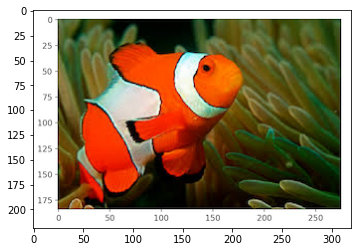

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
# You can read png, jpg and other file types 
img = cv2.imread('test-pic.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
plt.imshow(img) # show the image on the screen 
# You can find out the size of the image
print('Image size (height, width, num layers) is', img.shape)

px = img[145, 67] # img[y,x] is the color of the pixel of x,y
print(f'Pixel at (145,67) is {px}')
print(' pixels are RGB values.')



In [30]:
# load an image and make it into a graph.
import math
import cv2
def pixel_difference(px1, px2):
    def fix_pixels (px):
        return [int(px[0]), int(px[1]), int(px[2]) ]
    px1_float = fix_pixels(px1)
    px2_float = fix_pixels(px2)
    return max( abs(px1_float[0] - px2_float[0]), abs(px1_float[1] - px2_float[1]), abs(px1_float[2] - px2_float[2])) 

def get_index_from_pixel(i, j, height, width):
    assert 0 <= i < width
    assert 0 <= j < height
    return j * width + i

def get_coordinates_from_index(s, height, width):
    assert 0 <= s < height * width
    j = s//width
    i = s % width
    return (i,j)

def connect_neighboring_pixels(i, j, i1, j1, img, g):
    (height, width, _) = img.shape
    s = get_index_from_pixel(i, j, height, width)
    px = img[j,i]
    s1 = get_index_from_pixel(i1, j1, height, width)
    px1 = img[j1,i1]
    w = pixel_difference(px1, px)
    g.add_edge(s, s1, w)
    

def load_image_and_make_graph(imfilename):
    img = cv2.imread(imfilename)
    (height, width, num_layers) = img.shape
    g = UndirectedGraph(height * width)
    for j in range(height):
        for i in range(width):
            s = get_index_from_pixel(i, j, height, width)
            g.set_vertex_data(s, (i,j))
            if i > 0:
                connect_neighboring_pixels(i, j, i-1, j, img, g)
            if i < width -1:
                connect_neighboring_pixels(i, j, i+1, j, img, g)
            if j > 0:
                connect_neighboring_pixels(i, j, i, j-1, img, g)
            if j < height -1:
                connect_neighboring_pixels(i, j, i, j+1, img, g)
    return g
                
                
            


In [31]:
print('Loading image and building graph.')
g = load_image_and_make_graph('test-pic.png')
print('Running MST algorithm')
(mst_edges, mst_weight) = compute_mst(g)
print(f'Found MST witn {len(mst_edges)} edges and total weight = {mst_weight}')
max_mst_edge_weight= max(mst_edges, key=lambda e: e[2])
print(f'Largest MST edge weight = {max_mst_edge_weight[2]}')

Loading image and building graph.
Running MST algorithm
Found MST witn 70079 edges and total weight = 768962
Largest MST edge weight = 233


In [32]:
import numpy as np


    
def visualize_components(orig_image, g, components_dict):
    (w,h,channels) = orig_image.shape
    new_image = np.zeros((w, h, channels), np.uint8)
    count = 0
    delta = 10
    for (key, vertSet) in components_dict.items():
        if len(vertSet) >= 10: 
            (i,j) = g.get_vertex_data(key)
            rgb_px = orig_image[j,i]
            rgb_color = (int(rgb_px[0]), int(rgb_px[1]), int(rgb_px[2]))
            count = count+1          
            for s in vertSet:
                (i,j) = g.get_vertex_data(s)
                cv2.circle(new_image,(i,j), 1, rgb_color, -1) 
    return new_image

Found 32204 components
Showing components with at least 10 vertices


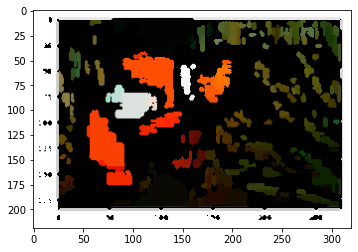

In [33]:
W0 = 0.01* max_mst_edge_weight[2]
res = compute_scc(g, W0)
print(f'Found {len(res)} components')
print('Showing components with at least 10 vertices')
new_img= visualize_components(img, g, res)
plt.imshow(new_img) # show the image on the screen 

Found 19904 components
Showing components with at least 10 vertices


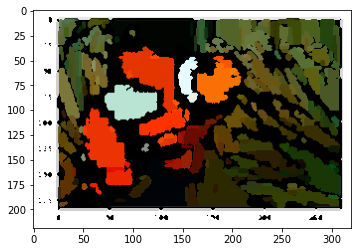

In [34]:
W0 = 0.02* max_mst_edge_weight[2]
res = compute_scc(g, W0)
print(f'Found {len(res)} components')
print('Showing components with at least 10 vertices')
new_img= visualize_components(img, g, res)
plt.imshow(new_img) # show the image on the screen 

Found 13075 components
Showing components with at least 10 vertices


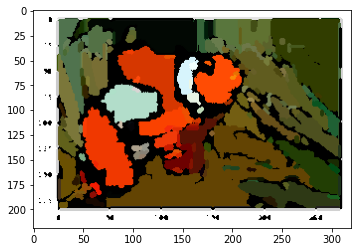

In [35]:
W0 = 0.03* max_mst_edge_weight[2]
res = compute_scc(g, W0)
print(f'Found {len(res)} components')
new_img= visualize_components(img, g, res)
print('Showing components with at least 10 vertices')
plt.imshow(new_img) # show the image on the screen 

Found 7933 components
Showing components with at least 10 vertices


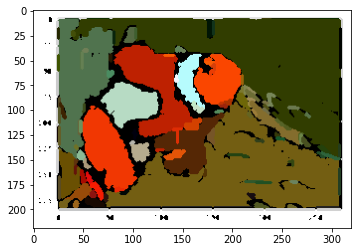

In [36]:
W0 = 0.04* max_mst_edge_weight[2]
res = compute_scc(g, W0)
print(f'Found {len(res)} components')
print('Showing components with at least 10 vertices')
new_img= visualize_components(img, g, res)
plt.imshow(new_img) # show the image on the screen 

Found 6066 components
Showing components with at least 10 vertices


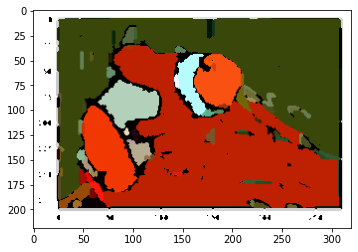

In [37]:
W0 = 0.05* max_mst_edge_weight[2]
res = compute_scc(g, W0)
print(f'Found {len(res)} components')
print('Showing components with at least 10 vertices')
new_img= visualize_components(img, g, res)
plt.imshow(new_img) # show the image on the screen 

Found 3495 components
Showing components with at least 10 vertices


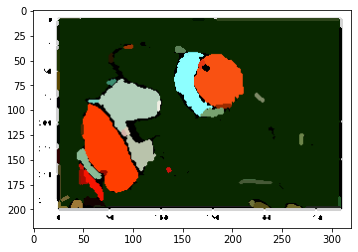

In [38]:
W0 = 0.07* max_mst_edge_weight[2]
res = compute_scc(g, W0)
print(f'Found {len(res)} components')
print('Showing components with at least 10 vertices')
new_img= visualize_components(img, g, res)
plt.imshow(new_img) # show the image on the screen 

Found 2057 components
Showing components with at least 10 vertices


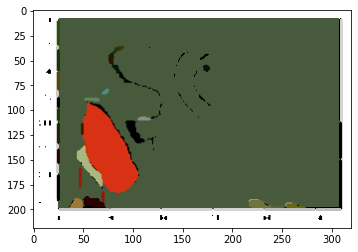

In [39]:
W0 = 0.1* max_mst_edge_weight[2]
res = compute_scc(g, W0)
print(f'Found {len(res)} components')
print('Showing components with at least 10 vertices')
new_img= visualize_components(img, g, res)
plt.imshow(new_img) # show the image on the screen 

# That's all Folks!